## Imports

In [52]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from arabert.preprocess import ArabertPreprocessor
from tensorflow.keras.layers import Dense , Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

## Load Datasets

In [54]:
# load arabic names
real_arabic_names = pd.read_csv(arabic_names_path)
# load male names
male = pd.read_csv(male_names_path, header=None, names=['Name'])
# load female names
female = pd.read_csv(female_names_path, header=None, names=['Name'])

In [55]:
# view first rows of real arabic names
real_arabic_names.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


In [56]:
# view last 5 rows of arabic names
real_arabic_names.tail()

,Name,Gender
1400,وهبة,M
1401,ياسر,M
1402,يحيى,M
1403,يزيد,M
1404,يعقوب,M


In [57]:
# view first 5 rows of male names
male.head()

,Name
0,أبان
1,أبو بكر
2,أبو حمزة
3,أحد
4,أحمد


In [58]:
# view last 5 rows of male names
male.tail()

,Name
635,وفيق
636,وهاب
637,وهبة
638,ياسر
639,يحيى


In [59]:
# view first 5 rows of female names
female.head()

,Name
0,آيات
1,آلاء
2,آمال
3,آمنة
4,آيات


In [60]:
# view last 5 rows of female names
female.tail()

,Name
411,وميض
412,وهبة
413,يارا
414,ياسمين
415,يسرا


In [61]:
# add gender column to male and female names
male['Gender'] = 'M'
female['Gender'] = 'F'

In [62]:
# merge male names with female names
names = pd.concat([male,female])
# merge the result with arabic names
real_names = pd.concat([real_arabic_names,names])

In [63]:
# add label column to the arabic names datasets that identifies that these names are real names
real_names['Label'] = 'Real'

In [64]:
# shape of the result of merging all real arabic names datasets
real_names.shape

(2461, 3)

In [66]:
# check and remove duplicates
names = check_duplicates(real_names, 'real names')

Number of duplicated names are:  909
The shape of  real names after deleting duplicates is: (1552, 3)


In [67]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1552 non-null   object
 1   Gender  1552 non-null   object
 2   Label   1552 non-null   object
dtypes: object(3)
memory usage: 36.5+ KB


In [68]:
names.describe()

,Name,Gender,Label
count,1552,1552,1552
unique,1552,2,1
top,ابتسام,M,Real
freq,1,929,1552


## Data generation

In [71]:
# create object of the DataGenerator class
generator = DataGenerator(arabic_alphabet)

For each name in the **_Arabic Names Dataset_**, we will generate **two** fake names by deleting a random character from the original name at random position, then generate **six** fake names by adding a  wrong character to the original name at random position, and **four** fake names by replacing a random single character from the original name with another wrong random character

**IMPORTANT NOTE**, we will not consider all possibilities of generating a fake name from an original name, as this will lead us to huge fake names maybe reach to more than **1,000,000!** fake name, So as a start it will be enough to generate **12x** fake names from the real names dataset

In [72]:
# generate 2 fake names by delete a char
f_names_deleted_char = names.apply(lambda x: generator.generate(mode='delete_char', num_of_words=2, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 4 fake names by replace a char
f_names_replaced_char = names.apply(lambda x: generator.generate(mode='replace_char', num_of_words=4, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)
# generate 6 fake names by adding a wrong char
f_names_adding_wrong_char = names.apply(lambda x: generator.generate(mode='add_char', num_of_words=6, 
                                                                name=x['Name'], gender=x['Gender']), axis=1)

In [74]:
# convert the output of the generator to one dictionary containing all names
deleted_char_df = one_dict(f_names_deleted_char)
replaced_char_df = one_dict(f_names_replaced_char)
added_char_df = one_dict(f_names_adding_wrong_char)
# concatenate the 3 dataframe to form the Fake Names Dataset
f_names = pd.concat([added_char_df, replaced_char_df, deleted_char_df],ignore_index=True)

In [75]:
# view first 5 rows of fake names
f_names.head()

,Name,Gender,Label
0,ابتساحم,F,Fake
1,ابتساةم,F,Fake
2,خابتسام,F,Fake
3,ابتغسام,F,Fake
4,ابتتسام,F,Fake


In [76]:
# view last 5 rows of fake names
f_names.tail()

,Name,Gender,Label
18619,مناة,F,Fake
18620,مين,F,Fake
18621,ميا,F,Fake
18622,نصاح,F,Fake
18623,نصحة,F,Fake


In [77]:
f_names.shape

(18624, 3)

In [78]:
f_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18624 entries, 0 to 18623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    18624 non-null  object
 1   Gender  18624 non-null  object
 2   Label   18624 non-null  object
dtypes: object(3)
memory usage: 436.6+ KB


In [79]:
f_names.describe()

,Name,Gender,Label
count,18624,18624,18624
unique,17842,2,1
top,عد,M,Fake
freq,7,11148,18624


In [80]:
# check and remove duplicates
f_names2 = check_duplicates(f_names, 'fake names')

Number of duplicated names are:  782
The shape of  fake names after deleting duplicates is: (17842, 3)


In [81]:
# check to see if there is a fake name exist in real names
# False indicates that this name will be deleted from the fake names dataset
# True indicates that this name will remain exist in the fake names dataset
fake_real_mask = [False if name in names['Name'] else True for name in f_names2['Name']]
print('Number of fake names that exist in real arabic names', len([fake_real_mask == False]))
fake_names = f_names2[fake_real_mask]

Number of fake names that exist in real arabic names 1


We have our real arabic names dataset and generated fake names dataset from our real arabic names, We will now create a **Full Name Dataset** consists of 3 names separated by space

We will create **Two Datasets**:
1. The first is full names with real arabic names, by generating **random 324 name** for each name in the real arabic names dataset
2. the second is full names with fake arabic names, by generating **random 30 name** for each name in the fake arabic names dataset

There is a difference in number of names in each dataset and that is because the dataframe of real names is smaller than by **12X** from the dataframe that contains fake names, so above numbers will give us balanced dataset of full names with equal number of examples for each class (Correct and Incorrect)

And if we choose to generate same number of names in the two dataset this will lead to **Imbalanced Dataset Problem**, and a memory problem may occur, so above numbers are enough

In [82]:
# full names with real arabic names
full_names_real = generator.generate_full_name(mode='Real', data=names,num_of_names=324)
# full names with fake arabic names
full_names_fake = generator.generate_full_name(mode='Fake', data=fake_names,num_of_names=30)

In [83]:
# combine the two dataset together into one
full_names = pd.concat([full_names_real,full_names_fake])
# shuffle the data
full_names = full_names.sample(frac=1)
# reset index
full_names = full_names.reset_index(drop=True)

In [84]:
# view first 5 rows of the full_names dataset
full_names.head()

,Name,Gender,Label
0,دهيم معاوية نذير,M,Correct
1,أحنف منصف عبدالحق,M,Correct
2,انشراح نادر عوني,F,Correct
3,شفيق نزيه ريبال,M,Correct
4,عفالح بجيعر قردر,M,Incorrect


In [85]:
# view last 5 rows of the full_names dataset
full_names.tail()

,Name,Gender,Label
1038103,البراء أشجع كارم,M,Correct
1038104,ريناد نايف عزب,F,Correct
1038105,كفصى علعيم أهرم,F,Incorrect
1038106,ذكاسر منهدل مطاضع,M,Incorrect
1038107,إجلال إمام جندل,F,Correct


In [86]:
full_names.shape

(1038108, 3)

In [87]:
full_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038108 entries, 0 to 1038107
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Name    1038108 non-null  object
 1   Gender  1038108 non-null  object
 2   Label   1038108 non-null  object
dtypes: object(3)
memory usage: 23.8+ MB


In [88]:
full_names.describe()

,Name,Gender,Label
count,1038108,1038108,1038108
unique,1038000,2,2
top,عدوان متمم عروة,M,Incorrect
freq,2,618036,535260


In [89]:
# check and remove duplicates
full_names = check_duplicates(full_names, 'full names')

Number of duplicated names are:  108
The shape of  full names after deleting duplicates is: (1038000, 3)


## Core Model

We will use the **Tokenizer** of **AraBERT** to convert our full names into tokens after that ids that represent each word to make data ready for my own Deep Learning Model

In [90]:
# load the tokenizer and preprocessor
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer =  AutoTokenizer.from_pretrained(model_name)
preprocessor = ArabertPreprocessor(model_name=model_name)

Prepare the data for the **Model**

In [91]:
# drop the gender column as it wouldn't be useful anymore
full_names = full_names.drop(columns=['Gender'])
# divide data into x that represents features and y that represent target
X = full_names.drop(columns=['Label'])
y = full_names[['Label']]
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [92]:
# reset index for all data
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

This method apply all transofrmation and preprocessing for the names data, as it converts it to **Tokens** and convert tokens into **IDs** and **Encodes** the labels of the data by converting them to **One Hot Encoding** return to us the data ready to be fed into my own Deep Learning Model

In [94]:
# transofrm X_train and y_train data
X_train , y_train = transform_data(X_train,y_train)
# transform X_test and y_test data
X_test , y_test = transform_data(X_test,y_test)

Define my own **Model Architecture**

In [95]:
# hyperparameters
VOCAB_SIZE = 10000
MAX_LEN = 50
EMBEDDING_DIM = 16
HIDDEN_SIZE = 32
NUM_CLASSES = 2
BATCH_SIZE = 512
EPOCHS = 35
LSTM_SIZE = 16
VAL_SLPIT = 0.15
OPTIMIZER = Adam()
LOSS = BinaryCrossentropy()
METRICS = ['accuracy']

In [97]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [98]:
# Training...
history = model.fit(x= X_train,y= y_train, batch_size= BATCH_SIZE, epochs = EPOCHS, validation_split= VAL_SLPIT)

Epoch 1/35
1465/1465 [==============================] - 122s 81ms/step - loss: 0.5131 - accuracy: 0.7508 - val_loss: 0.4659 - val_accuracy: 0.7800
Epoch 2/35
1465/1465 [==============================] - 119s 81ms/step - loss: 0.4514 - accuracy: 0.7975 - val_loss: 0.4171 - val_accuracy: 0.8090
Epoch 3/35
1465/1465 [==============================] - 114s 78ms/step - loss: 0.3937 - accuracy: 0.8301 - val_loss: 0.3640 - val_accuracy: 0.8368
Epoch 4/35
1465/1465 [==============================] - 116s 79ms/step - loss: 0.3471 - accuracy: 0.8536 - val_loss: 0.3150 - val_accuracy: 0.8659
Epoch 5/35
1465/1465 [==============================] - 133s 91ms/step - loss: 0.3108 - accuracy: 0.8723 - val_loss: 0.2902 - val_accuracy: 0.8782
Epoch 6/35
1465/1465 [==============================] - 141s 96ms/step - loss: 0.2863 - accuracy: 0.8845 - val_loss: 0.2674 - val_accuracy: 0.8896
Epoch 7/35
1465/1465 [==============================] - 143s 97ms/step - loss: 0.2669 - accuracy: 0.8943 - val_loss: 0

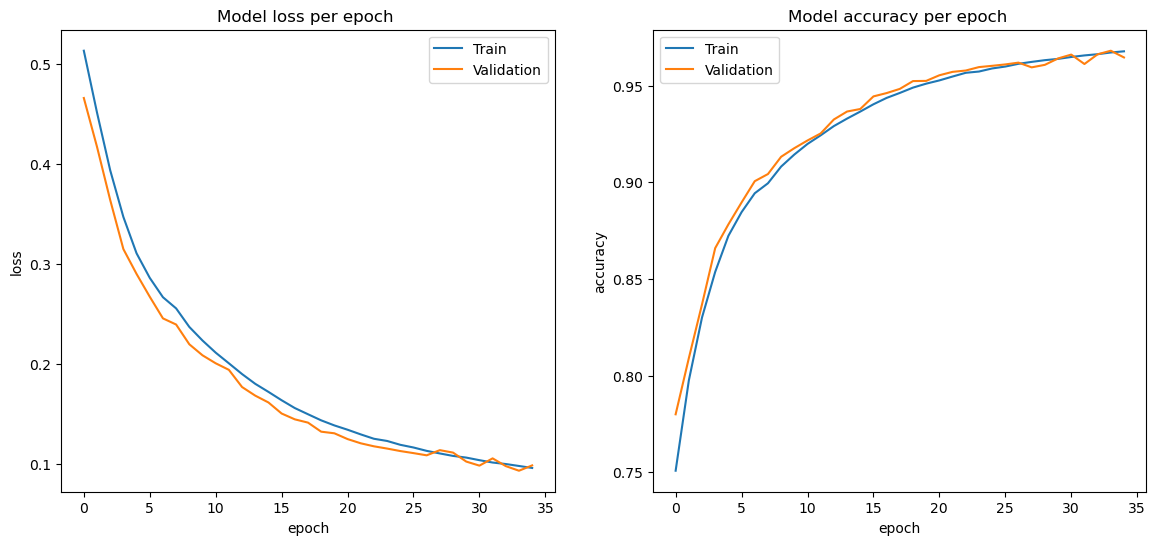

In [100]:
plot_curves(history)

Perform predictions and calculate the **accuarcy** on the Test Data to determine the performance of the model

In [102]:
y_pred = predictions(model, X_test)
# convert predictions to dataframe
y_pred = pd.DataFrame(y_pred, columns=['Correct','Incorrect'])
accuracy = accuracy_score(y_test, y_pred)
print('The accuracy of the model on Test Data is:', accuracy)

4866/4866 [==============================] - 30s 6ms/step
The accuracy of the model on Test Data is: 0.9656840077071291


Saving the weights of the Model 

In [103]:
saved_model_name = 'name_verification_model.h5'
model.save_weights(saved_model_name,save_format='h5')